In [1]:
# load packages 
%matplotlib inline
import os
import glob
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import geopandas as gpd
import pyproj
import shapely.geometry
from matplotlib.ticker import FormatStrFormatter
import matplotlib as mpl
import numpy as np
import xarray as xr
import rioxarray as rxr
from geocube.api.core import make_geocube
import xesmf as xe
import cartopy.crs as ccrs
import contextily as ctx

# imports for rasterizing 
import geopandas as gpd
import rasterio
from rasterio import features
from rasterio.enums import MergeAlg
from rasterio.plot import show
import xwrf

# dask
import dask
from dask.distributed import Client, LocalCluster

In [1]:
# # Create a LocalCluster that will automatically use all available cores
# cluster = LocalCluster()

# # Connect the Dask client to the cluster
# client = Client(cluster)

# # Print the client information and dashboard link
# client

In [2]:
# import US Census Urban Area vector file
home_path = Path('/home1/kojoseph/anthropogenic-heat-la-20230205')
data_path = home_path / 'data'
filepath = data_path / 'boundaries/2016_urban_area.geojson'
urban = gpd.read_file(filepath)
# import la county boundary
filename = data_path / 'boundaries/la_county_bound_simplified.gpkg'
la_county = gpd.read_file(filename)
# urban areas in la county
urban = urban.to_crs(la_county.crs)
urban_la_county = urban.overlay(la_county)
# urban_la_county.plot()

/home1/kojoseph/.conda/envs/geo_env_clone/lib/python3.9/site-packages/geopandas/tools/overlay.py:299: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[mask, col] = df.loc[mask, col].buffer(0)


In [3]:
# test read wrfout file
test_folder = '/project2/zhan248_1326/hhao4018/WRFv4.6.1_Modified_AHoption_noChem/test/JOE_Default_2016_08_ah=0/wrfout_d02*'
print(f'test folder: {test_folder}')
filelist = glob.glob(test_folder)
ds = xr.open_mfdataset(filelist, 
                    engine="netcdf4",
                    concat_dim="Time",
                    combine="nested").xwrf.postprocess()
ds

test folder: /project2/zhan248_1326/hhao4018/WRFv4.6.1_Modified_AHoption_noChem/test/JOE_Default_2016_08_ah=0/wrfout_d02*


<xarray.Dataset>
Dimensions:                    (Time: 217, y: 192, x: 244, z: 44,
                                urban_wind_directions_stag: 4, z_stag: 45)
Coordinates:
    XLAT                       (y, x) float32 dask.array<chunksize=(192, 244), meta=np.ndarray>
    XLONG                      (y, x) float32 dask.array<chunksize=(192, 244), meta=np.ndarray>
    XTIME                      (Time) timedelta64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
  * Time                       (Time) datetime64[ns] 2016-08-10 ... 2016-08-19
  * y                          (y) float64 -4.254e+05 -4.244e+05 ... -2.344e+05
  * x                          (x) float64 1.325e+05 1.335e+05 ... 3.755e+05
Dimensions without coordinates: z, urban_wind_directions_stag, z_stag
Data variables: (12/99)
    Times                      (Time) |S19 dask.array<chunksize=(1,), meta=np.ndarray>
    LU_INDEX                   (Time, y, x) float32 dask.array<chunksize=(1, 192, 244), meta=np.ndarray>
    Q2                         (Time, y, x) float32 dask.array<chunksize=(1, 192, 244), meta=np.ndarray>
    T2                         (Time, y, x) float32 dask.array<chunksize=(1, 192, 244), meta=np.ndarray>
    PSFC                       (Time, y, x) float32 dask.array<chunksize=(1, 192, 244), meta=np.ndarray>
    U10                        (Time, y, x) float32 dask.array<chunksize=(1, 192, 244), meta=np.ndarray>
    ...                         ...
    LANDMASK                   (Time, y, x) float32 dask.array<chunksize=(1, 192, 244), meta=np.ndarray>
    LAKEMASK                   (Time, y, x) float32 dask.array<chunksize=(1, 192, 244), meta=np.ndarray>
    SST                        (Time, y, x) float32 dask.array<chunksize=(1, 192, 244), meta=np.ndarray>
    SST_INPUT                  (Time, y, x) float32 dask.array<chunksize=(1, 192, 244), meta=np.ndarray>
    air_potential_temperature  (Time, z, y, x) float32 dask.array<chunksize=(1, 44, 192, 244), meta=np.ndarray>
    wrf_projection             object +proj=lcc +x_0=0 +y_0=0 +a=6370000 +b=6...
Attributes: (12/136)
    TITLE:                            OUTPUT FROM WRF V4.6.0 MODEL
    START_DATE:                      2016-08-10_00:00:00
    SIMULATION_START_DATE:           2016-08-10_00:00:00
    WEST-EAST_GRID_DIMENSION:        245
    SOUTH-NORTH_GRID_DIMENSION:      193
    BOTTOM-TOP_GRID_DIMENSION:       45
    ...                              ...
    ISLAKE:                          21
    ISICE:                           15
    ISURBAN:                         13
    ISOILWATER:                      14
    HYBRID_OPT:                      0
    ETAC:                            0.0

# Plots for Jiachen

In [4]:
def process_delta(ds_control, ds_target, vars_subset, clip_gdf, timezone_shift=-7):
    control = ds_control[vars_subset]
    target = ds_target[vars_subset]
    delta = target - control
    delta = delta.compute()
    # assign crs
    wrf_crs = ds_control.wrf_projection.item()
    delta = delta.rio.write_crs(wrf_crs)
    # clip by urban LA County pixels
    delta_clipped = delta.rio.clip(clip_gdf.geometry.values, clip_gdf.crs)
    # remove first two days (spin-up) and last timestep (extra timestep)
    delta_clipped = delta_clipped.isel(Time=slice(48, -1))
    # create local hour variable
    # delta_clipped['hour'] = (delta_clipped['Time'].dt.hour - 7)%24
    delta_clipped = delta_clipped.assign_coords(hour=(delta_clipped['Time'].dt.hour+timezone_shift)%24)
    return delta_clipped

In [6]:
# load wrfout files
wrf_folder = '/project2/zhan248_1326/hhao4018/WRFv4.6.1_Modified_AHoption_noChem/test'
months = [8, 12]
case = 'Default'
vars_subset = ['T2', 'TC_URB']
delta = {}
for month in months:
    # control
    filepath_control = os.path.join(wrf_folder, f'JOE_Default_2016_{month:02d}_ah=0/wrfout_d02*')
    print(f'control: {filepath_control}')
    filelist_control = glob.glob(filepath_control)
    ds_control = xr.open_mfdataset(filelist_control, 
                        engine="netcdf4",
                        concat_dim="Time",
                        combine="nested").xwrf.postprocess()
    ds_control = ds_control.sortby('Time')
    # target
    filepath_target = os.path.join(wrf_folder, f'JOE_{case}_{month:02d}_ah=2_GDAS_frac_urb/wrfout_d02*')
    print(f'target: {filepath_target}')
    filelist_target = glob.glob(filepath_target)
    ds_target = xr.open_mfdataset(filelist_target, 
                        engine="netcdf4",
                        concat_dim="Time",
                        combine="nested").xwrf.postprocess()
    ds_target = ds_target.sortby('Time')
    # create delta ds
    if (month >= 3) and (month < 11): # PDT (~March - Nov)
        timezone_shift =-7
    else: # PST
        timezone_shift=-8
    delta_clipped = process_delta(ds_control, ds_target, vars_subset, urban_la_county, timezone_shift)
    delta[month] = delta_clipped

control: /project2/zhan248_1326/hhao4018/WRFv4.6.1_Modified_AHoption_noChem/test/JOE_Default_2016_08_ah=0/wrfout_d02*
target: /project2/zhan248_1326/hhao4018/WRFv4.6.1_Modified_AHoption_noChem/test/JOE_Default_08_ah=2_GDAS_frac_urb/wrfout_d02*
control: /project2/zhan248_1326/hhao4018/WRFv4.6.1_Modified_AHoption_noChem/test/JOE_Default_2016_12_ah=0/wrfout_d02*
target: /project2/zhan248_1326/hhao4018/WRFv4.6.1_Modified_AHoption_noChem/test/JOE_Default_12_ah=2_GDAS_frac_urb/wrfout_d02*


In [7]:
# pre-define labels for easy re-use
# \mathrm{} prevents exprsesion from getting italicized 
# \/ within the latex expression is necessary for an empty space
degree_sign = u'\N{DEGREE SIGN}'
del_ta_label = r'$\mathrm{{\Delta}T_{air}}$ (' + degree_sign + 'C)'
del_tc_label = r'$\mathrm{{\Delta}T_{canopy}}$ (' + degree_sign + 'C)'
ahf_label = r'Anthropogenic heat flux ($\mathrm{W\/m^{-2}}$)'
ws_label = r'$\mathrm{{\Delta}}$(Wind Speed) ($\mathrm{m\/s^{-1}}$)'
pblh_label = r'$\mathrm{{\Delta}}$PBLH (m)'

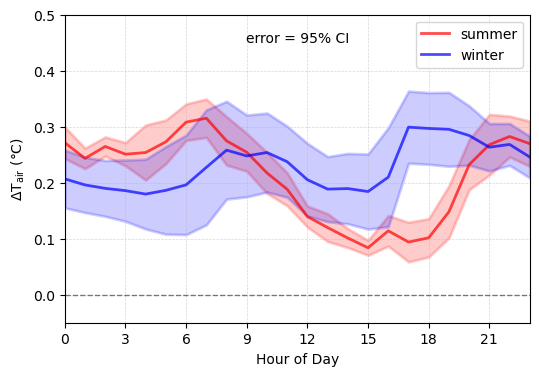

In [11]:
# Diurnal plot for delta(T2)
v = 'T2'
mean_dict = {}
ci_lower = {}
ci_upper = {}
for m in delta.keys():
    mean = delta[m][v].mean(dim=['y','x'], skipna=True)
    mean_diurnal = mean.groupby('hour').mean('Time')
    std_diurnal = mean.groupby('hour').std('Time')
    n_sample = len(mean[mean['hour']==0])
    err_diurnal = 1.96*(std_diurnal/(n_sample)**(1/2))
    mean_dict[m] = mean_diurnal
    ci_lower[m] = mean_diurnal - err_diurnal
    ci_upper[m] = mean_diurnal + err_diurnal
# initiate plot
fig, ax = plt.subplots(figsize=(6,4))
hrs = range(24)
# summer
ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax.plot(hrs, mean_dict[8],'red',label='summer',linewidth=2, alpha=0.7)
ax.fill_between(hrs, ci_upper[8], ci_lower[8],
                alpha=0.2, edgecolor='red', facecolor='red',
                linewidth=2, antialiased=True)
# winter
ax.plot(hrs, mean_dict[12],'blue',label='winter',linewidth=2, alpha=0.7)
ax.fill_between(hrs, ci_upper[12], ci_lower[12],
                alpha=0.2, edgecolor='blue', facecolor='blue',
                linewidth=2, antialiased=True)
ax.xaxis.set_ticks(np.arange(0,24,3))
ax.grid(linewidth=0.5, alpha=0.5, linestyle='--')
ax.set_xlabel('Hour of Day')
ax.set_ylabel(del_ta_label)
ax.legend()
ax.set_xlim(0, 23)
ax.set_ylim(-0.05, 0.5)
ax.annotate('error = 95% CI', xy=(0.5, 0.9), xycoords='axes fraction', 
            fontsize=10, horizontalalignment='center', verticalalignment='bottom')
save_dir = '../figs'
filename = 'diurnal_t2.png'
plt.savefig(os.path.join(save_dir, filename), dpi=300)

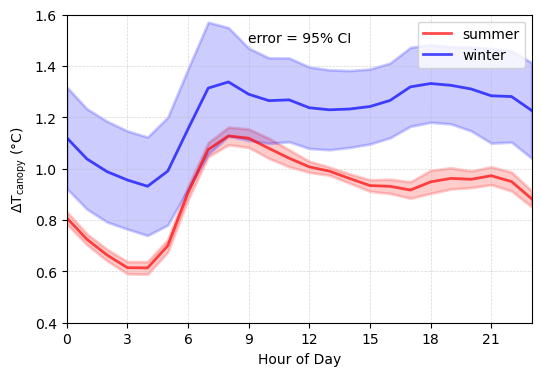

In [15]:
# Diurnal plot for delta(TC_URB)
v = 'TC_URB'
mean_dict = {}
ci_lower = {}
ci_upper = {}
for m in delta.keys():
    mean = delta[m][v].mean(dim=['y','x'], skipna=True)
    mean_diurnal = mean.groupby('hour').mean('Time')
    std_diurnal = mean.groupby('hour').std('Time')
    n_sample = len(mean[mean['hour']==0])
    err_diurnal = 1.96*(std_diurnal/(n_sample)**(1/2))
    mean_dict[m] = mean_diurnal
    ci_lower[m] = mean_diurnal - err_diurnal
    ci_upper[m] = mean_diurnal + err_diurnal
# initiate plot
fig, ax = plt.subplots(figsize=(6,4))
hrs = range(24)
# summer
ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax.plot(hrs, mean_dict[8],'red',label='summer',linewidth=2, alpha=0.7)
ax.fill_between(hrs, ci_upper[8], ci_lower[8],
                alpha=0.2, edgecolor='red', facecolor='red',
                linewidth=2, antialiased=True)
# winter
ax.plot(hrs, mean_dict[12],'blue',label='winter',linewidth=2, alpha=0.7)
ax.fill_between(hrs, ci_upper[12], ci_lower[12],
                alpha=0.2, edgecolor='blue', facecolor='blue',
                linewidth=2, antialiased=True)
ax.xaxis.set_ticks(np.arange(0,24,3))
ax.grid(linewidth=0.5, alpha=0.5, linestyle='--')
ax.set_xlabel('Hour of Day')
ax.set_ylabel(del_tc_label)
ax.legend()
ax.set_xlim(0, 23)
ax.set_ylim(0.4, 1.6)
ax.annotate('error = 95% CI', xy=(0.5, 0.9), xycoords='axes fraction', 
            fontsize=10, horizontalalignment='center', verticalalignment='bottom')
save_dir = '../figs'
filename = 'diurnal_tc.png'
plt.savefig(os.path.join(save_dir, filename), dpi=300)

## Black background

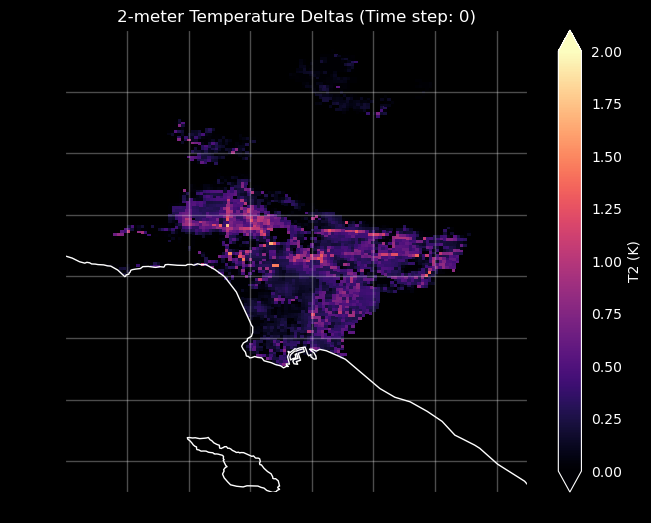

In [19]:
# Diurnal delta(T2) GIF, summer
delta_clipped = delta[8]['T2']
delta_clipped = delta_clipped.groupby('hour').mean('Time')
# Extract latitude, longitude, and temperature data
lat = delta_clipped['XLAT'][:]
lon = delta_clipped['XLONG'][:]

# Set up the plot
fig = plt.figure(figsize=(8, 6))
fig.patch.set_facecolor('black')  # Set figure background to black
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ax.set_facecolor('black')  # Set axes background to black
ax.set_extent([-119, -117.5, 33.3, 34.8], crs=ccrs.PlateCarree())

# Initialize pcolormesh with the first frame of the data
z = delta_clipped.isel(hour=0)
c = ax.pcolormesh(lon, lat, z, cmap='magma', shading='auto', vmin=0, vmax=2)

# Add coastlines and gridlines
ax.coastlines(color='white')
ax.gridlines(draw_labels=['left', 'bottom'], 
             linewidth=1, alpha=0.3, color='white')

# Add a colorbar for the temperature
cbar = fig.colorbar(c, ax=ax, extend='both')
cbar.set_label("T2 (K)", color='white')  # Set label color to white
# Set color of colorbar ticks to white
for label in cbar.ax.get_yticklabels():
    label.set_color('white')
# Set colorbar outline to white
cbar.outline.set_edgecolor('white')  # Set the color of the outline to white

# Set title
ax.set_title("2-meter Temperature Deltas (target - control)", color='white')

# Update function for animation
def update(frame):
    # Extract temperature data for the current timestep (frame)
    z = delta_clipped.isel(hour=frame)
    
    # Update the pcolormesh with new data
    c.set_array(z.values.flatten())
    
    # Update title with the current timestep
    ax.set_title(f"2-meter Temperature Deltas (Time step: {frame})", color='white')
    
    return c,

# Create the animation
ani = FuncAnimation(fig, update, frames=len(delta_clipped['hour']), blit=False, interval=1000)
ani_dir = '../figs/ani'
os.makedirs(ani_dir, exist_ok=True)
ani_path = os.path.join(ani_dir, 'delta-t2-default.gif')
ani.save(ani_path, writer='ffmpeg', fps=2)

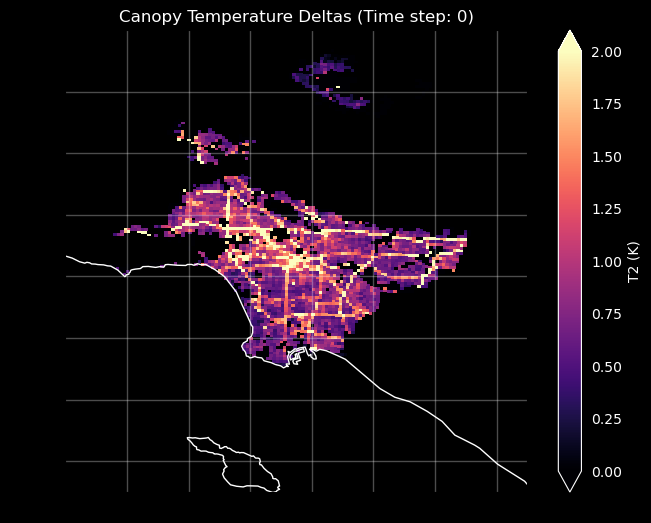

In [20]:
# Diurnal delta(TC_URB) GIF, summer
delta_clipped = delta[8]['TC_URB']
delta_clipped = delta_clipped.groupby('hour').mean('Time')
# Extract latitude, longitude, and temperature data
lat = delta_clipped['XLAT'][:]
lon = delta_clipped['XLONG'][:]

# Set up the plot
fig = plt.figure(figsize=(8, 6))
fig.patch.set_facecolor('black')  # Set figure background to black
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ax.set_facecolor('black')  # Set axes background to black
ax.set_extent([-119, -117.5, 33.3, 34.8], crs=ccrs.PlateCarree())

# Initialize pcolormesh with the first frame of the data
z = delta_clipped.isel(hour=0)
c = ax.pcolormesh(lon, lat, z, cmap='magma', shading='auto', vmin=0, vmax=2)

# Add coastlines and gridlines
ax.coastlines(color='white')
ax.gridlines(draw_labels=['left', 'bottom'], 
             linewidth=1, alpha=0.3, color='white')

# Add a colorbar for the temperature
cbar = fig.colorbar(c, ax=ax, extend='both')
cbar.set_label("T2 (K)", color='white')  # Set label color to white
# Set color of colorbar ticks to white
for label in cbar.ax.get_yticklabels():
    label.set_color('white')
# Set colorbar outline to white
cbar.outline.set_edgecolor('white')  # Set the color of the outline to white

# Set title
ax.set_title("Canopy Temperature Deltas (target - control)", color='white')

# Update function for animation
def update(frame):
    # Extract temperature data for the current timestep (frame)
    z = delta_clipped.isel(hour=frame)
    
    # Update the pcolormesh with new data
    c.set_array(z.values.flatten())
    
    # Update title with the current timestep
    ax.set_title(f"Canopy Temperature Deltas (Time step: {frame})", color='white')
    
    return c,

# Create the animation
ani = FuncAnimation(fig, update, frames=len(delta_clipped['hour']), blit=False, interval=1000)
ani_dir = '../figs/ani'
os.makedirs(ani_dir, exist_ok=True)
ani_path = os.path.join(ani_dir, 'delta-tc-default.gif')
ani.save(ani_path, writer='ffmpeg', fps=2)

## White background

In [21]:
mpl.rcdefaults()

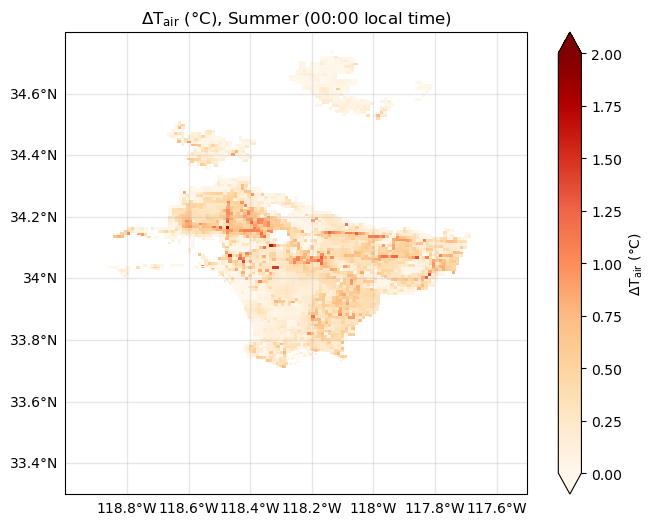

In [22]:
# Diurnal delta(T2) GIF, summer
delta_clipped = delta[8]['T2']
delta_clipped = delta_clipped.groupby('hour').mean('Time')

# Extract latitude, longitude, and temperature data
lat = delta_clipped['XLAT'][:]
lon = delta_clipped['XLONG'][:]

# Set up the plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ax.set_extent([-119, -117.5, 33.3, 34.8], crs=ccrs.PlateCarree())

# Initialize pcolormesh with the first frame of the data
z = delta_clipped.isel(hour=0)
c = ax.pcolormesh(lon, lat, z, cmap='OrRd', shading='auto', vmin=0, vmax=2)

# Add coastlines and gridlines
ax.coastlines(color='white')
ax.gridlines(draw_labels=['left', 'bottom'], linewidth=1, alpha=0.3)

# Add a colorbar for the temperature
cbar = fig.colorbar(c, ax=ax, extend='both')
cbar.set_label(f"{del_ta_label}")

# Create directory for PNGs
png_dir = '/home1/kojoseph/anthropogenic-heat-la-20230205/plots/plots-for-jiachen-20250502/delta-t2-default-whitebg-frames'
os.makedirs(png_dir, exist_ok=True)

# Update function for animation
def update(frame):
    z = delta_clipped.isel(hour=frame)
    c.set_array(z.values.flatten())
    ax.set_title(f"{del_ta_label}, Summer ({frame:02d}:00 local time)")
    return c,

# Save individual PNGs
for i in range(len(delta_clipped['hour'])):
    update(i)  # Manually update the frame
    plt.savefig(f"{png_dir}/frame_{i:02d}.png", dpi=150)  # Save each frame

# Create the animation GIF
ani = FuncAnimation(fig, update, frames=len(delta_clipped['hour']), blit=False, interval=1000)
ani_dir = '../figs/ani'
os.makedirs(ani_dir, exist_ok=True)
ani_path = os.path.join(ani_dir, 'delta-t2-default-whitebg.gif')
ani.save(ani_path, writer='ffmpeg', fps=3)


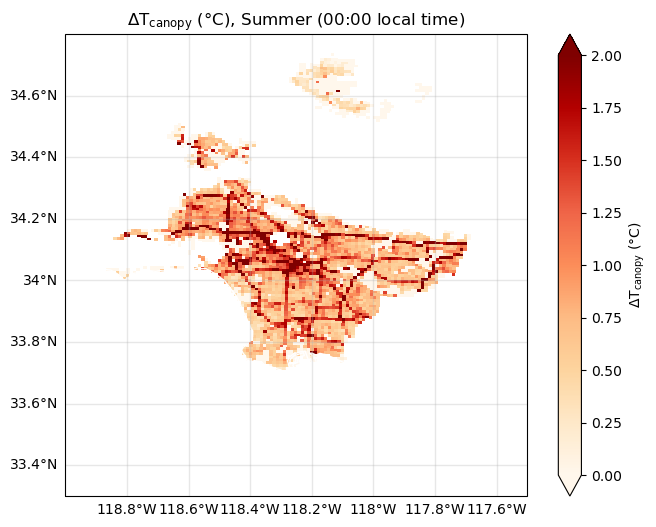

In [23]:
# Diurnal delta(T2) GIF, summer
delta_clipped = delta[8]['TC_URB']
delta_clipped = delta_clipped.groupby('hour').mean('Time')

# Extract latitude, longitude, and temperature data
lat = delta_clipped['XLAT'][:]
lon = delta_clipped['XLONG'][:]

# Set up the plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ax.set_extent([-119, -117.5, 33.3, 34.8], crs=ccrs.PlateCarree())

# Initialize pcolormesh with the first frame of the data
z = delta_clipped.isel(hour=0)
c = ax.pcolormesh(lon, lat, z, cmap='OrRd', shading='auto', vmin=0, vmax=2)

# Add coastlines and gridlines
ax.coastlines(color='white')
ax.gridlines(draw_labels=['left', 'bottom'], linewidth=1, alpha=0.3)

# Add a colorbar for the temperature
cbar = fig.colorbar(c, ax=ax, extend='both')
cbar.set_label(f"{del_tc_label}")

# Create directory for PNGs
png_dir = '/home1/kojoseph/anthropogenic-heat-la-20230205/plots/plots-for-jiachen-20250502/delta-tc-default-whitebg-frames'
os.makedirs(png_dir, exist_ok=True)

# Update function for animation
def update(frame):
    z = delta_clipped.isel(hour=frame)
    c.set_array(z.values.flatten())
    ax.set_title(f"{del_tc_label}, Summer ({frame:02d}:00 local time)")
    return c,

# Save individual PNGs
for i in range(len(delta_clipped['hour'])):
    update(i)  # Manually update the frame
    plt.savefig(f"{png_dir}/frame_{i:02d}.png", dpi=150)  # Save each frame

# Create the animation GIF
ani = FuncAnimation(fig, update, frames=len(delta_clipped['hour']), blit=False, interval=1000)
ani_dir = '../figs/ani'
os.makedirs(ani_dir, exist_ok=True)
ani_path = os.path.join(ani_dir, 'delta-tc-default-whitebg.gif')
ani.save(ani_path, writer='ffmpeg', fps=3)

In [ ]:
# load wrfout files
wrf_folder = '/project2/zhan248_1326/hhao4018/WRFv4.6.1_Modified_AHoption_noChem/test'
month = 8
case = 'Default'
# control
filepath_control = os.path.join(wrf_folder, f'JOE_Default_{month:02d}_ah=0_GDAS/wrfout_d02*')
print(f'control: {filepath_control}')
filelist_control = glob.glob(filepath_control)
ds_control = xr.open_mfdataset(filelist_control, 
                       engine="netcdf4",
                       concat_dim="Time",
                       combine="nested").xwrf.postprocess()
ds_control = ds_control.sortby('Time')
# target
filepath_target = os.path.join(wrf_folder, f'JOE_{case}_{month:02d}_ah=2_GDAS_frac_urb/wrfout_d02*')
print(f'target: {filepath_target}')
filelist_target = glob.glob(filepath_target)
ds_target = xr.open_mfdataset(filelist_target, 
                       engine="netcdf4",
                       concat_dim="Time",
                       combine="nested").xwrf.postprocess()
ds_target = ds_target.sortby('Time')

In [ ]:
# pre-define labels for easy re-use
# \mathrm{} prevents exprsesion from getting italicized 
# \/ within the latex expression is necessary for an empty space
degree_sign = u'\N{DEGREE SIGN}'
del_ta_label = r'$\mathrm{{\Delta}T_{air}}$ (' + degree_sign + 'C)'
ahf_label = r'Anthropogenic heat flux ($\mathrm{W\/m^{-2}}$)'
ws_label = r'$\mathrm{{\Delta}}$(Wind Speed) ($\mathrm{m\/s^{-1}}$)'
pblh_label = r'$\mathrm{{\Delta}}$PBLH (m)'

In [ ]:
def process_delta(ds_control, ds_target, vars_subset, clip_gdf):
    control = ds_control[vars_subset]
    target = ds_target[vars_subset]
    delta = target - control
    delta = delta.compute()
    # assign crs
    wrf_crs = ds_control.wrf_projection.item()
    delta = delta.rio.write_crs(wrf_crs)
    # clip by urban LA County pixels
    delta_clipped = delta.rio.clip(clip_gdf.geometry.values, clip_gdf.crs)
    # remove first two days (spin-up) and last timestep (extra timestep)
    delta_clipped = delta_clipped.isel(Time=slice(48, -1))
    # create local hour variable
    # delta_clipped['hour'] = (delta_clipped['Time'].dt.hour - 7)%24
    delta_clipped = delta_clipped.assign_coords(hour=(delta_clipped['Time'].dt.hour - 7)%24)
    return delta_clipped

def get_error(mean_diurnal, std_diurnal, n_sample, error_type='std'):
    if error_type == 'std':
        err_diurnal = std_diurnal
    elif error_type == 'ci95':
        err_diurnal = 1.96*(std_diurnal/(n_sample)**(1/2))
    else:
        print('invalid: defaulting to std')
        err_diurnal = std_diurnal
    ci_upper = mean_diurnal + err_diurnal
    ci_lower = mean_diurnal - err_diurnal
    return ci_lower, ci_upper

# diff_mean = delta_clipped.mean(dim=['y','x'], skipna=True)
# hr_avg = diff_mean.groupby('hour').mean('Time')
# hr_std = diff_mean.groupby('hour').std('Time')
# hrs = range(24)
# diff_ci_upper = hr_avg + hr_std
# diff_ci_lower = hr_avg - hr_std

def diurnal_plot(ds, v, error_type=None, savepath=None):
    ds = ds[v].copy()
    # arr = ds[0].to_numpy()
    # n_sample = np.sum(~np.isnan(arr))
    ds_mean = ds.mean(dim=['y','x'], skipna=True)
    mean_diurnal = ds_mean.groupby('hour').mean('Time')
    std_diurnal = ds_mean.groupby('hour').std('Time')
    n_sample = len(ds_mean[ds_mean['hour']==0])
    hrs = range(24)
    fig, ax = plt.subplots(figsize=(8,4))
    ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    print(type(mean_diurnal))
    ax.plot(hrs, mean_diurnal,'red',label='summer',linewidth=2, alpha=0.7)
    ax.xaxis.set_ticks(np.arange(0,24,3))
    ax.grid(linewidth=0.5, alpha=0.5, linestyle='--')
    ax.set_xlabel('Hour of Day')
    ax.set_ylabel(f'{v}')
    ax.set_xlim(0, 23)
    if error_type != None:
        ci_lower, ci_upper = get_error(mean_diurnal, std_diurnal, n_sample, error_type)
        ax.fill_between(hrs, ci_lower, ci_upper,
                        alpha=0.2, edgecolor='red', facecolor='red',
                        linewidth=2, antialiased=True)
        ax.annotate(f'error = {error_type}', xy=(0.15, 0.9), xycoords='axes fraction', 
                    fontsize=10, horizontalalignment='center', verticalalignment='bottom')
    if savepath != None:
        plt.savefig(savepath, dpi=300, bbox_inches='tight')
    plt.show()

In [ ]:
vars_subset = ['T2', 'TC_URB', 'U10', 'V10', 'PBLH']
months = [8, 12]
ah_option = 1
wrf_folder = '/project2/zhan248_1326/hhao4018/WRFv4.6.1_Modified_AHoption_noChem/test'
savedir = f'/home1/kojoseph/anthropogenic-heat-la-20230205/plots/diurnal_deltas_ah={ah_option}'
os.makedirs(savedir, exist_ok=True)
for month in months:
    files_list_dict = {
        'default' : {
            'target' : f'JOE_Default_{month:02d}_ah={ah_option}_GDAS_frac_urb/wrfout_d02*',
            'control' : f'JOE_Default_{month:02d}_ah=0_GDAS/wrfout_d02*'
        },
        'high' : {
            'target' : f'JOE_High_{month:02d}_ah={ah_option}_GDAS_frac_urb/wrfout_d02*',
            'control' : f'JOE_Default_{month:02d}_ah={ah_option}_GDAS_frac_urb/wrfout_d02*'
        },
        'medium' : {
            'target' : f'JOE_Medium_{month:02d}_ah={ah_option}_GDAS_frac_urb/wrfout_d02*',
            'control' : f'JOE_Default_{month:02d}_ah={ah_option}_GDAS_frac_urb/wrfout_d02*'
        },
        'low' : {
            'target' : f'JOE_Low_{month:02d}_ah={ah_option}_GDAS_frac_urb/wrfout_d02*',
            'control' : f'JOE_Default_{month:02d}_ah={ah_option}_GDAS_frac_urb/wrfout_d02*'
        }
    }
    for scenario in files_list_dict.keys():
        filepath_control = os.path.join(wrf_folder, files_list_dict[scenario]['control'])
        filepath_target = os.path.join(wrf_folder, files_list_dict[scenario]['target'])
        filelist_control = glob.glob(filepath_control)
        ds_control = xr.open_mfdataset(filelist_control, 
                            engine="netcdf4",
                            concat_dim="Time",
                            combine="nested").xwrf.postprocess()
        ds_control = ds_control.sortby('Time')
        filelist_target = glob.glob(filepath_target)
        ds_target = xr.open_mfdataset(filelist_target, 
                            engine="netcdf4",
                            concat_dim="Time",
                            combine="nested").xwrf.postprocess()
        ds_target = ds_target.sortby('Time')
        delta_clipped = process_delta(ds_control, ds_target, vars_subset, urban_la_county)
        for v in vars_subset:
            savename = f'delta_{v}_{scenario}_{month:02d}.png'
            print(f'creating plot: {savename}')
            savepath = os.path.join(savedir, savename)
            diurnal_plot(delta_clipped, v, error_type='ci95', savepath=savepath)

In [ ]:
vars_subset = ['T2', 'TC_URB', 'U10', 'V10', 'PBLH']
delta_clipped = process_delta(ds_control, ds_target, vars_subset, urban_la_county)


In [ ]:
diurnal_plot(delta_clipped, 'T2', error_type='ci95')

# T2

In [ ]:
# delta_T
control = ds_control['T2']
target = ds_target['T2']

In [ ]:
delta = target - control
delta = delta.compute()

In [ ]:
wrf_crs = ds_control.wrf_projection.item()
delta = delta.rio.write_crs(wrf_crs)

In [ ]:
# # clip by US Census Urban Area vector file
# filepath = data_path / 'boundaries/2016_urban_area.geojson'
# urban = gpd.read_file(filepath)
# t2_delta_clipped = t2_delta.rio.clip(urban.geometry.values, urban.crs)
delta_clipped = delta.rio.clip(urban_la_county.geometry.values, urban_la_county.crs)
delta_clipped['hour'] = (delta_clipped['Time'].dt.hour - 7)%24
# delta_clipped['hour'] = delta_clipped['Time'].dt.hour

In [ ]:
# sample size of urban LA County pixels
arr = delta_clipped[0].to_numpy()
n_sample = np.sum(~np.isnan(arr))
print(f'number of urban grid cells in LA County: {n_sample}')

In [ ]:
# check date range of ds
print(f'# timesteps: {len(delta_clipped.Time)}')
print(delta_clipped.Time.min())
print(delta_clipped.Time.max())

In [ ]:
# remove first two days (spin-up) and last timestep (extra timestep)
delta_clipped = delta_clipped.isel(Time=slice(48, -1))
delta_clipped

In [ ]:
# check AHF input files
ahf_folder = '/project/zhan248_1326/shared_resources/data/ahf/1km-v01/08'
ahf_path = os.path.join(ahf_folder, 'ahf_default_08.npy')
ahf = np.load(ahf_path)
ahf_mean = np.mean(ahf, axis=(1,2))
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 6))
# plot in local time (above)
hrs = range(24) 
axes[0].plot(hrs, ahf_mean)
axes[0].set_xlabel('Hour (local time)')
axes[0].set_ylabel('Mean AHF (W*m2)')
axes[0].set_xticks(np.arange(0, 24, 3))
# plot in UTC (below)
hrs_utc = (np.array(hrs) + 7)%24
sorted_indices = np.argsort(hrs_utc)
hrs_utc = hrs_utc[sorted_indices]
ahf_mean_utc = ahf_mean[sorted_indices]
axes[1].plot(hrs_utc, ahf_mean_utc)
axes[1].set_xlabel('Hour (UTC)')
axes[1].set_ylabel('Mean AHF (W*m2)')
axes[1].set_xticks(np.arange(0, 24, 3))
# Set the overall title for the entire figure
fig.suptitle('AHF from numpy files (source)', fontsize=16)

In [ ]:
# diurnal plot of AHF (from WRF input)
wrf_run = '/project2/zhan248_1326/hhao4018/WRFv4.6.1_Modified_AHoption_noChem/test/JOE_Default_08_ah=2_GDAS_frac_urb'
timesteps = range(216)
ahf = []
for t in timesteps:
    t_str = str(t).zfill(4)
    filepath = os.path.join(wrf_run, t_str)
    arr = np.loadtxt(filepath, delimiter=',', skiprows=1)
    ahf.append(arr)
ahf = np.array(ahf)
ahf = ahf[:24]
ahf_mean = np.mean(ahf, axis=(1,2))
hrs = np.array(range(24))
hrs_local = (hrs - 7)%24 # PT = UTC - 7 (in summer)
sorted_indices = np.argsort(hrs_local)
hrs_local = hrs_local[sorted_indices]
ahf_mean_local = ahf_mean[sorted_indices]
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 6))
# plot in local time (above)
axes[0].plot(hrs_local, ahf_mean_local)
axes[0].set_xlabel('Hour (local time)')
axes[0].set_ylabel('Mean AHF (W*m2)')
axes[0].set_xticks(np.arange(0, 24, 3))
# plot in UTC (below)
axes[1].plot(hrs, ahf_mean)
axes[1].set_xlabel('Hour (UTC)')
axes[1].set_ylabel('Mean AHF (W*m2)')
axes[1].set_xticks(np.arange(0, 24, 3))
# Set the overall title for the entire figure
fig.suptitle('AHF input from WRF run folder', fontsize=16)

In [ ]:
# diurnal plot of AHF (from WRF output)
ds_target_clipped = ds_target.isel(Time=slice(48, -1))
ahf = ds_target_clipped['AHFLUX']
# ahf = ds_control['AHFLUX']
ahf['hour'] = ahf['Time'].dt.hour
ahf_mean = ahf.groupby('hour').mean(dim=['Time','x','y'], skipna=True)
hrs = np.array(range(24))
hrs_local = (hrs - 7)%24 # PT = UTC - 7 (in summer)
sorted_indices = np.argsort(hrs_local)
hrs_local = hrs_local[sorted_indices]
ahf_mean_local = ahf_mean[sorted_indices]
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 6))
# plot in local time (above)
axes[0].plot(hrs_local, ahf_mean_local)
axes[0].set_xlabel('Hour (local time)')
axes[0].set_ylabel('Mean AHF (W*m2)')
axes[0].set_xticks(np.arange(0, 24, 3))
# plot in UTC (below)
axes[1].plot(hrs, ahf_mean)
axes[1].set_xlabel('Hour (UTC)')
axes[1].set_ylabel('Mean AHF (W*m2)')
axes[1].set_xticks(np.arange(0, 24, 3))
# Set the overall title for the entire figure
fig.suptitle('AHF from WRF output', fontsize=16)

In [ ]:
diff_mean.load()

In [ ]:
diff_mean.Time.dt.hour

In [ ]:
diff_mean = delta_clipped.mean(dim=['y','x'], skipna=True)
hr_avg = diff_mean.groupby('Time.hour').mean('Time')
print('using delta clipped')
print(hr_avg.load())

delta_local = delta_clipped.copy()
delta_local['Time'] = delta_local['Time'] - np.timedelta64(7, 'h')
diff_mean = delta_local.mean(dim=['y','x'], skipna=True)
hr_avg = diff_mean.groupby('Time.hour').mean('Time')
print('using delta local')
print(hr_avg.load())

In [ ]:
# Diurnal plot for T2: with std of daily mean

# Shift time to local timezone (UTC - 7)
# delta_local = delta_clipped.copy()
# delta_local['Time'] = delta_local['Time'] - np.timedelta64(7, 'h')

diff_mean = delta_clipped.mean(dim=['y','x'], skipna=True)
hr_avg = diff_mean.groupby('hour').mean('Time')
hr_std = diff_mean.groupby('hour').std('Time')
hrs = range(24)
diff_ci_upper = hr_avg + hr_std
diff_ci_lower = hr_avg - hr_std

fig, ax = plt.subplots(figsize=(8,4))
ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax.plot(hrs, hr_avg,'red',label='summer',linewidth=2, alpha=0.7)
ax.fill_between(hrs, diff_ci_upper, diff_ci_lower,
                alpha=0.2, edgecolor='red', facecolor='red',
                linewidth=2, antialiased=True)
ax.xaxis.set_ticks(np.arange(0,24,3))
ax.grid(linewidth=0.5, alpha=0.5, linestyle='--')
ax.set_xlabel('Hour of Day')
ax.set_ylabel('delta_T2')
ax.set_xlim(0, 23)
ax.annotate('error = std of daily mean', xy=(0.15, 0.9), xycoords='axes fraction', 
            fontsize=10, horizontalalignment='center', verticalalignment='bottom')

In [ ]:
# Diurnal plot for T2: with 95% confidence interval
diff_mean = delta_clipped.groupby('hour').mean(dim=['Time','y','x'], skipna=True)
diff_std = delta_clipped.groupby('hour').std(dim=['Time','y','x'], skipna=True)
hrs = range(24)
diff_ci_upper = diff_mean + 1.96*(diff_std/(n_sample)**(1/2))
diff_ci_lower = diff_mean - 1.96*(diff_std/(n_sample)**(1/2))

fig, ax = plt.subplots(figsize=(8,4))
hrs = range(24)
ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax.plot(hrs, hr_avg,'red',label='summer',linewidth=2, alpha=0.7)
ax.fill_between(hrs, diff_ci_upper, diff_ci_lower,
                alpha=0.2, edgecolor='red', facecolor='red',
                linewidth=2, antialiased=True)
ax.xaxis.set_ticks(np.arange(0,24,3))
ax.grid(linewidth=0.5, alpha=0.5, linestyle='--')
ax.set_xlabel('Hour of Day')
ax.set_ylabel('delta_T2')
ax.set_xlim(0, 23)
ax.annotate('error = 95% CI over grid points', xy=(0.7, 0.88), xycoords='axes fraction', 
            fontsize=10, horizontalalignment='center', verticalalignment='bottom')

In [ ]:
# Histogram
fig, ax = plt.subplots(figsize=(8,4))
mean_val = delta_clipped.mean().values
delta_clipped.plot.hist(ax=ax, xlim =[-0.5, 1.5], bins='scott',
                    histtype='stepfilled',
                    edgecolor='red', linewidth=2,
                    density=True, alpha=0.5, fc=(1, 0, 0, 0.5));
# Plot the mean as a vertical line on the histogram
plt.axvline(mean_val, color='red', linestyle='--', label=f'Mean = {mean_val:.2f}')
ax.grid(linewidth=0.5, alpha=0.3, linestyle='--')
ax.set_xlabel(del_ta_label)
ax.set_ylabel('Density')
ax.legend()
ax.axvline(x=0, color='black', linestyle='-', linewidth=1, alpha=0.5)
ax.set_title('')
# save_dir = plots_path/'wrf_analysis/delta_histograms'
# filename = 'hist_t2_20231209.png'
# plt.savefig(save_dir / filename, dpi=300)

In [ ]:
# Plot single snapshot
# Extract latitude, longitude, and temperature
lat = delta_clipped['XLAT'][:]
lon = delta_clipped['XLONG'][:]
z = delta_clipped.isel(Time=123)
# plot
fig = plt.figure(figsize=(8, 6))
fig.patch.set_facecolor('black')  # Set figure background to black
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ax.set_facecolor('black')  # Set axes background to black
ax.set_extent([-119, -117.5, 33.3, 34.8], crs=ccrs.PlateCarree())
# Plot the temperature data
c = ax.pcolormesh(lon, lat, z, cmap='magma', shading='auto', vmin=0, vmax=1)
# Add coastlines and gridlines
ax.coastlines(color='white')
ax.gridlines(draw_labels=['left', 'bottom'], 
             linewidth=1, alpha=0.3, color='white')
# Add a colorbar for the temperature
cbar = fig.colorbar(c, ax=ax, extend='both')
cbar.set_label("T2 (K)", color='white')  # Set label color to white
# Set color of colorbar ticks to white
for label in cbar.ax.get_yticklabels():
    label.set_color('white')
# Set colorbar outline to white
cbar.outline.set_edgecolor('white')  # Set the color of the outline to white
# Set a title
ax.set_title("2-meter Temperature Deltas (target - control)", color='white')
# Show the plot
plt.show()

In [ ]:
# Plot animation as GIF
# Extract latitude, longitude, and temperature data
lat = delta_clipped['XLAT'][:]
lon = delta_clipped['XLONG'][:]

# Set up the plot
fig = plt.figure(figsize=(8, 6))
fig.patch.set_facecolor('black')  # Set figure background to black
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ax.set_facecolor('black')  # Set axes background to black
ax.set_extent([-119, -117.5, 33.3, 34.8], crs=ccrs.PlateCarree())

# Initialize pcolormesh with the first frame of the data
z = delta_clipped.isel(Time=0)
c = ax.pcolormesh(lon, lat, z, cmap='magma', shading='auto', vmin=0, vmax=2)

# Add coastlines and gridlines
ax.coastlines(color='white')
ax.gridlines(draw_labels=['left', 'bottom'], 
             linewidth=1, alpha=0.3, color='white')

# Add a colorbar for the temperature
cbar = fig.colorbar(c, ax=ax, extend='both')
cbar.set_label("T2 (K)", color='white')  # Set label color to white
# Set color of colorbar ticks to white
for label in cbar.ax.get_yticklabels():
    label.set_color('white')
# Set colorbar outline to white
cbar.outline.set_edgecolor('white')  # Set the color of the outline to white

# Set title
ax.set_title("2-meter Temperature Deltas (target - control)", color='white')

# Update function for animation
def update(frame):
    # Extract temperature data for the current timestep (frame)
    z = delta_clipped.isel(Time=frame)
    
    # Update the pcolormesh with new data
    c.set_array(z.values.flatten())
    
    # Update title with the current timestep
    ax.set_title(f"2-meter Temperature Deltas (Time step: {frame})", color='white')
    
    return c,

# Create the animation
ani = FuncAnimation(fig, update, frames=len(delta_clipped['Time']), blit=False, interval=1000)
ani_path = '/home1/kojoseph/anthropogenic-heat-la-20230205/plots/wrf_analysis/delta-t2-default-v2.gif'
ani.save(ani_path, writer='ffmpeg', fps=2)

# TC

In [ ]:
# delta_T
variable = 'TC_URB'
control = ds_control[variable]
target = ds_target[variable]
delta = target - control
delta = delta.compute()
# clip to urban areas of LA County
delta = delta.rio.write_crs(wrf_crs)
delta_clipped = delta.rio.clip(urban_la_county.geometry.values, urban_la_county.crs)

In [ ]:
# Diurnal plot for TC: with std of daily mean
diff_mean = delta_clipped.mean(dim=['y','x'], skipna=True)
diff_mean['hour'] = diff_mean['Time'].dt.hour
hr_avg = diff_mean.groupby('hour').mean('Time')
hr_std = diff_mean.groupby('hour').std('Time')
hrs = range(24)
diff_ci_upper = hr_avg + hr_std
diff_ci_lower = hr_avg - hr_std

fig, ax = plt.subplots(figsize=(8,4))
hrs = range(24)
ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax.plot(hrs, hr_avg,'red',label='summer',linewidth=2, alpha=0.7)
ax.fill_between(hrs, diff_ci_upper, diff_ci_lower,
                alpha=0.2, edgecolor='red', facecolor='red',
                linewidth=2, antialiased=True)
ax.xaxis.set_ticks(np.arange(0,24,3))
ax.grid(linewidth=0.5, alpha=0.5, linestyle='--')
ax.set_xlabel('Hour of Day')
ax.set_ylabel(f'{variable}')
ax.set_xlim(0, 23)
ax.annotate('error = std of daily mean', xy=(0.15, 0.9), xycoords='axes fraction', 
            fontsize=10, horizontalalignment='center', verticalalignment='bottom')

In [ ]:
# diurnal plot
diff_mean = delta_clipped.mean(dim=['y','x'], skipna=True)
diff_std = delta_clipped.std(dim=['y','x'], skipna=True)
diff_ci_upper = diff_mean + 1.96*(diff_std/(n_sample)**(1/2))
diff_ci_lower = diff_mean - 1.96*(diff_std/(n_sample)**(1/2))

fig, ax = plt.subplots(figsize=(8,4))
hrs = range(24)
ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax.plot(hrs, diff_mean[25:49],'red',label='summer',linewidth=2, alpha=0.7)
ax.fill_between(hrs, diff_ci_upper[25:49], diff_ci_lower[25:49],
                alpha=0.2, edgecolor='red', facecolor='red',
                linewidth=2, antialiased=True)
ax.xaxis.set_ticks(np.arange(0,24,3))
ax.grid(linewidth=0.5, alpha=0.5, linestyle='--')
ax.set_xlabel('Hour of Day')
ax.set_ylabel('delta_TC')
ax.set_xlim(0, 23)
ax.annotate('error = 95% CI', xy=(0.15, 0.9), xycoords='axes fraction', 
            fontsize=10, horizontalalignment='center', verticalalignment='bottom')

In [ ]:
# Extract latitude, longitude, and temperature
lat = delta_clipped['XLAT'][:]
lon = delta_clipped['XLONG'][:]
z = delta_clipped.isel(Time=10)
# plot
fig = plt.figure(figsize=(8, 6))
fig.patch.set_facecolor('black')  # Set figure background to black
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ax.set_facecolor('black')  # Set axes background to black
ax.set_extent([-119, -117.5, 33.3, 34.8], crs=ccrs.PlateCarree())
# Plot the temperature data
c = ax.pcolormesh(lon, lat, z, cmap='magma', shading='auto', vmin=0, vmax=1)
# Add coastlines and gridlines
ax.coastlines(color='white')
ax.gridlines(draw_labels=['left', 'bottom'], 
             linewidth=1, alpha=0.3, color='white')
# Add a colorbar for the temperature
cbar = fig.colorbar(c, ax=ax, extend='both')
cbar.set_label("TC (K)", color='white')  # Set label color to white
# Set color of colorbar ticks to white
for label in cbar.ax.get_yticklabels():
    label.set_color('white')
# Set colorbar outline to white
cbar.outline.set_edgecolor('white')  # Set the color of the outline to white
# Set a title
ax.set_title("Canopy Temperature Deltas (target - control)", color='white')
# Show the plot
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib.animation import FuncAnimation

# Extract latitude, longitude, and temperature data
lat = delta_clipped['XLAT'][:]
lon = delta_clipped['XLONG'][:]

# Set up the plot
fig = plt.figure(figsize=(8, 6))
fig.patch.set_facecolor('black')  # Set figure background to black
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ax.set_facecolor('black')  # Set axes background to black
ax.set_extent([-119, -117.5, 33.3, 34.8], crs=ccrs.PlateCarree())

# Initialize pcolormesh with the first frame of the data
z = delta_clipped.isel(Time=0)
c = ax.pcolormesh(lon, lat, z, cmap='magma', shading='auto', vmin=0, vmax=2)

# Add coastlines and gridlines
ax.coastlines(color='white')
ax.gridlines(draw_labels=['left', 'bottom'], 
             linewidth=1, alpha=0.3, color='white')

# Add a colorbar for the temperature
cbar = fig.colorbar(c, ax=ax, extend='both')
cbar.set_label("Delta TC (K)", color='white')  # Set label color to white
# Set color of colorbar ticks to white
for label in cbar.ax.get_yticklabels():
    label.set_color('white')
# Set colorbar outline to white
cbar.outline.set_edgecolor('white')  # Set the color of the outline to white

# Set title
ax.set_title("Canopy Temperature Deltas (target - control)", color='white')

# Update function for animation
def update(frame):
    # Extract temperature data for the current timestep (frame)
    z = delta_clipped.isel(Time=frame)
    
    # Update the pcolormesh with new data
    c.set_array(z.values.flatten())
    
    # Update title with the current timestep
    ax.set_title(f"Canopy Temperature Deltas (Time step: {frame})", color='white')
    
    return c,

# Create the animation
ani = FuncAnimation(fig, update, frames=len(t2_delta_clipped['Time']), blit=False, interval=1000)
ani_path = '/home1/kojoseph/anthropogenic-heat-la-20230205/plots/wrf_analysis/delta-tc-default.gif'
ani.save(ani_path, writer='ffmpeg', fps=2)